%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../smc')

In [331]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import sys

In [332]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *
from wsc import *

In [279]:
# Matrix shape and rank
n1, n2 = 100, 100
k = 3
r = 3
prop_obs = 0.2
random_state = 1
allow_inf = False
alpha = 0.1

# Experiment 1: spatial conditional coverage


In [280]:
max_test_queries = 1000
bias_scale = 2
sampler = QuerySampling(n1,n2)
bias = SamplingBias(n1,n2)

# Split observation mask uniformly
mask_obs, mask_miss = sampler.sample_submask(sub_size=prop_obs, random_state=random_state)

# Sample test queries with weights
w = bias.inc_weights(scale = bias_scale)
n_test_queries = min(np.sum(np.sum(mask_miss, axis=1) // k), max_test_queries)
idxs_test= sampler.sample_test(mask_miss, k, test_size=n_test_queries, w=w, replace=True, random_state=random_state)

In [281]:
# Generate a random true matrix 
RFM = RandomFactorizationModel(n1 ,n2, r)
U, V, M = RFM.sample_noiseless(random_state)

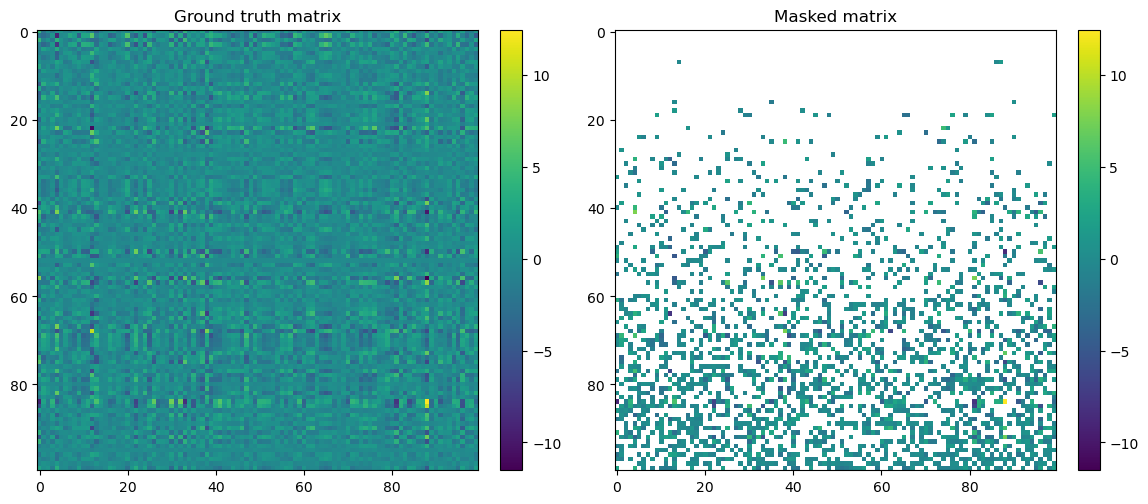

Test entries are masked in white, unique test entries: 2230


In [282]:
mask_test = np.zeros_like(mask_miss)
mask_test[idxs_test]=1
plot_before_after_mask(M, mask_test, bad_color="white")
print("Test entries are masked in white, unique test entries: {}".format(np.sum(mask_test)))

In [298]:
max_calib_queries = 1000
n_calib_queries = min(int(0.5 * np.sum(np.sum(mask_obs, axis=1) // k)), max_calib_queries)
mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, k, 
                                        calib_size=n_calib_queries, random_state=random_state)

print("Observation size: {}, training size: {},  calib queries: {}, test queries: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), int(np.sum(mask_calib)//k), len(idxs_test[0])//k))

# Train matrix completion model
Mhat, Uhat, Vhat = pmf_solve(M, mask_train, k=r, random_state=random_state)

Observation size: 2000, training size: 1049,  calib queries: 317, test queries: 1000
Iteration: 1; Mean diff: 0.0008
Iteration: 2; Mean diff: 0.0001
Iteration: 3; Mean diff: 0.0001
Iteration: 4; Mean diff: 0.0000
Iteration: 5; Mean diff: 0.0000
Iteration: 6; Mean diff: 0.0000
Iteration: 7; Mean diff: 0.0000
Iteration: 8; Mean diff: 0.0000
Iteration: 9; Mean diff: 0.0000
Iteration: 10; Mean diff: 0.0000
Iteration: 11; Mean diff: 0.0000
Iteration: 12; Mean diff: 0.0000
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Stopping criteria met, training t

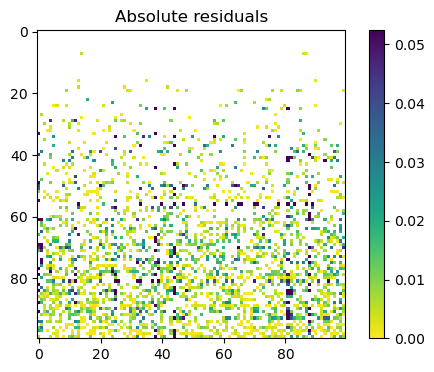

In [299]:
error_heatmap(M, Mhat, mask_test)

In [285]:
ci_method = SimulCI(M, Mhat, mask_obs, idxs_calib, k)
df = ci_method.get_CI(idxs_test, alpha, w_test= w, allow_inf=allow_inf)
lower, upper, is_inf= df.loc[0].lower, df.loc[0].upper, df.loc[0].is_inf
res = evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method="SMC-conditional")

Computing conformal prediction intervals for 1000 test queries...


CI: 100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.60it/s]

Done!


In [286]:
res

,Query_coverage,Coverage,Size,Inf_prop,Method
0,0.916,0.968667,0.145225,0.0,SMC-conditional


In [287]:
df_uncond = ci_method.get_CI(idxs_test, alpha, allow_inf=allow_inf)
lower, upper, is_inf= df_uncond.loc[0].lower, df_uncond.loc[0].upper, df_uncond.loc[0].is_inf
res_uncond = evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method="SMC-unconditional")

Computing conformal prediction intervals for 1000 test queries...


CI: 100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.63it/s]

Done!


In [288]:
res_uncond

,Query_coverage,Coverage,Size,Inf_prop,Method
0,0.897,0.961667,0.127504,0.0,SMC-unconditional


# Experiment 2: worst slice coverage

In [300]:
max_test_queries = 1000
sampler = QuerySampling(n1,n2)
bias = SamplingBias(n1,n2)

# Split observation mask uniformly
mask_obs, mask_miss = sampler.sample_submask(sub_size=prop_obs, random_state=random_state)

# Generate a random true matrix 
RFM = RandomFactorizationModel(n1 ,n2, r)
U, V, M = RFM.sample_noiseless(random_state)

# Generate calib queries
max_calib_queries = 1000
n_calib_queries = min(int(0.5 * np.sum(np.sum(mask_obs, axis=1) // k)), max_calib_queries)
mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, k, 
                                        calib_size=n_calib_queries, random_state=random_state)

print("Observation size: {}, training size: {},  calib queries: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), int(np.sum(mask_calib)//k)))

# Train matrix completion model
Mhat, Uhat, Vhat = pmf_solve(M, mask_train, k=r, random_state=random_state)

Observation size: 2000, training size: 1049,  calib queries: 317
Iteration: 1; Mean diff: 0.0008
Iteration: 2; Mean diff: 0.0001
Iteration: 3; Mean diff: 0.0001
Iteration: 4; Mean diff: 0.0000
Iteration: 5; Mean diff: 0.0000
Iteration: 6; Mean diff: 0.0000
Iteration: 7; Mean diff: 0.0000
Iteration: 8; Mean diff: 0.0000
Iteration: 9; Mean diff: 0.0000
Iteration: 10; Mean diff: 0.0000
Iteration: 11; Mean diff: 0.0000
Iteration: 12; Mean diff: 0.0000
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Stopping criteria met, training terminated.


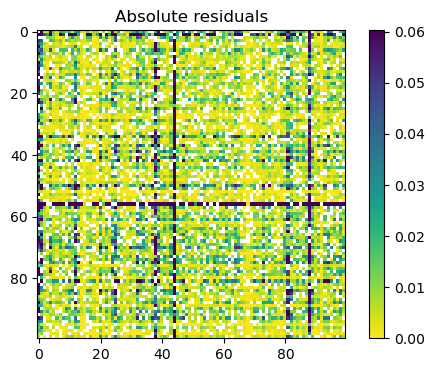

In [301]:
error_heatmap(M, Mhat, mask_miss)

In [344]:
wsc_param, mask_test = wsc_estimate(M, Mhat, Uhat, Vhat, mask_miss, random_state=random_state)

In [374]:
w = bias.latent_weights(Uhat, Vhat, r, *wsc_param, scale=(wsc_param[2]-wsc_param[1])/5)

In [375]:
n_test_queries = min(np.sum(np.sum(mask_test, axis=1) // k), max_test_queries)
idxs_test= sampler.sample_test(mask_test, k, test_size=n_test_queries, w=w, replace=True, random_state=random_state)

In [376]:
mask_test_sub = np.zeros_like(mask_miss)
mask_test_sub[idxs_test]=1

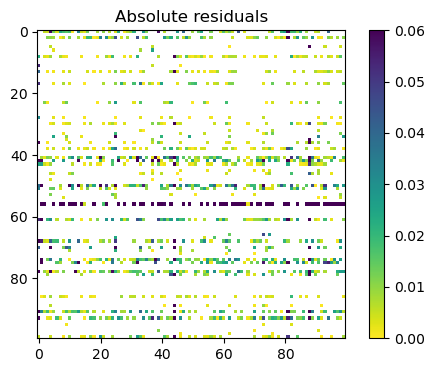

In [377]:
error_heatmap(M, Mhat, mask_test_sub, vmin=0, vmax=0.06)

In [378]:
np.sum(mask_test_sub)

1295

In [380]:
ci_method = SimulCI(M, Mhat, mask_obs, idxs_calib, k)
df = ci_method.get_CI(idxs_test, alpha, w_test= w, allow_inf=allow_inf)
lower, upper, is_inf= df.loc[0].lower, df.loc[0].upper, df.loc[0].is_inf
res = evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method="SMC-conditional")

Computing conformal prediction intervals for 1000 test queries...


CI: 100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.75it/s]

Done!


In [381]:
res

,Query_coverage,Coverage,Size,Inf_prop,Method
0,0.928,0.971,0.692469,0.004,SMC-conditional


In [382]:
df_uncond = ci_method.get_CI(idxs_test, alpha, allow_inf=allow_inf)
lower, upper, is_inf= df_uncond.loc[0].lower, df_uncond.loc[0].upper, df_uncond.loc[0].is_inf
res_uncond = evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method="SMC-unconditional")

Computing conformal prediction intervals for 1000 test queries...


CI: 100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.82it/s]

Done!


In [383]:
res_uncond

,Query_coverage,Coverage,Size,Inf_prop,Method
0,0.839,0.912333,0.128181,0.0,SMC-unconditional
